In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
from PIL import Image, ExifTags, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm

torch.backends.cudnn.benchmark = True

In [2]:
def extractCoordinates(image_path):
    img = Image.open(image_path)
    exif_data = img._getexif()
    if not exif_data:
        return None

    gps_info = {}
    for tag, value in exif_data.items():
        decoded = ExifTags.TAGS.get(tag, tag)
        if decoded == "GPSInfo":
            # Map the inner GPS tags (e.g., 1: 'GPSLatitudeRef', 2: 'GPSLatitude'...)
            for t in value:
                sub_decoded = ExifTags.GPSTAGS.get(t, t)
                gps_info[sub_decoded] = value[t]

    # If GPS data exists, calculate the decimals
    if "GPSLatitude" in gps_info and "GPSLongitude" in gps_info:
        lat_dms = gps_info["GPSLatitude"]
        lat_ref = gps_info["GPSLatitudeRef"]
        lon_dms = gps_info["GPSLongitude"]
        lon_ref = gps_info["GPSLongitudeRef"]

        # Helper to convert DMS to Decimal
        def dms_to_decimal(dms, ref):
            # dms is a list of 3 rationals [(deg_num, deg_den), (min, den), (sec, den)]
            deg = float(dms[0])
            minute = float(dms[1])
            sec = float(dms[2])

            decimal = deg + (minute / 60.0) + (sec / 3600.0)
            if ref in ['S', 'W']:
                decimal = -decimal
            return decimal

        lat = dms_to_decimal(lat_dms, lat_ref) 
        lon = dms_to_decimal(lon_dms, lon_ref)

        return lat, lon

    return None


In [3]:
def aspect_crop(img):
    """
    Standardizes mixed datasets to 4:3 aspect ratio.
    - If image is 4:3, it does nothing
    - If image is 18:9, it crops Sky/Ground to match 4:3
    """
    w, h = img.size
    current_ratio = w / h
    target_ratio = 3 / 4  # 0.75

    # If already close to 4:3, do nothing
    if abs(current_ratio - target_ratio) < 0.05:
        return img

    # If image is too tall (Portrait), Crop top and bottom
    if current_ratio < target_ratio:
        # Calculate new height to achieve 4:3 based on current width
        new_h = int(w / target_ratio) 
        pixels_to_remove = h - new_h
        
        # remove 30% from top (sky), then 70% from bottom (ground)
        top_crop = int(pixels_to_remove * 0.3)
        
        return TF.crop(img, top_crop, 0, new_h, w)

    # Fallback: If image is too wide (Landscape), CenterCrop it
    return TF.center_crop(img, (h * 3 // 4, h))

In [4]:
def haversine_distance(coord1, coord2):
    """
    Calculates the distance in meters between two points on the earth.
    Input: Arrays of [Latitude, Longitude]
    """
    # Earth's radius in meters
    R = 6371000.0 
    
    # Convert degrees to radians
    lat1, lon1 = np.radians(coord1[:, 0]), np.radians(coord1[:, 1])
    lat2, lon2 = np.radians(coord2[:, 0]), np.radians(coord2[:, 1])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

In [5]:
class GeolocalizationDataset(Dataset):
  def __init__(self, image_paths, coordinates, use_dropout=False, use_dropout2d=False, is_train =False):
    self.image_paths = image_paths
    self.coordinates = coordinates
    self.image_tensors = []

    print(f"Caching {len(image_paths)} images in RAM...")
    for path in tqdm(image_paths):
      with Image.open(path) as img:
        # Store as RGB Tensor in RAM to skip disk I/O later
        tensor_img = T.ToTensor()(img.convert('RGB'))
        self.image_tensors.append(tensor_img)

    transformations = []

    if is_train:
      transformations.append(T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5))
      transformations.append(T.RandomGrayscale(p=0.2))
        

    transformations.extend([
      T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    self.transform = T.Compose(transformations)


  def __len__(self):
    return len(self.image_paths)


  def __getitem__(self, idx):
    image = self.image_tensors[idx]
    image = self.transform(image)

    coord = torch.tensor(self.coordinates[idx], dtype=torch.float32)

    return image, coord

In [6]:
# Function to plot 10 images and their filenames
def plot_images_from_dataloader(dataloader, num_images=10):
    # Get the first batch of images and labels
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    # Move images to CPU for visualization
    images = images[:num_images].cpu()
    
    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.229 + 0.485  # Unnormalize (mean and std from T.Normalize)
        img = img.clip(0, 1)  # Clip values to [0, 1] for display
        
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Image {i+1}")
    
    plt.tight_layout()
    plt.show()

In [7]:
class ConvNet(nn.Module):
    def __init__(self, use_dropout=False, use_dropout2d=False):
        super(ConvNet, self).__init__()

        self.use_dropout = use_dropout
        self.use_dropout2d = use_dropout2d

        self.conv1 = nn.Conv2d(3, 128, 5, padding='same')
        self.conv2 = nn.Conv2d(128, 64, 3, padding='same')

        if self.use_dropout2d:
            self.spatial_dropout = nn.Dropout2d(p=0.2)

        # Global Average Pooling ensures this stays 64 regardless of image size
        self.fc1 = nn.Linear(64, 256)

        if self.use_dropout:
            self.dropout = nn.Dropout(p=0.5)

        # 2. Vector of 2 for [Latitude, Longitude]
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = self.conv2(x)

        if self.use_dropout2d:
            x = self.spatial_dropout(x)

        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, 1) # Global Avg Pool
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)

        x = self.fc2(x) # Linear output for regression
        return x

In [8]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        # 'p' is a learnable parameter. 
        # p=1 is Average Pooling, p=Infinity is Max Pooling. 
        # The model will learn the best value between them.
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        # The GeM formula
        return F.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(1./self.p)

In [9]:
class ConvNet2(nn.Module):
    def __init__(self, use_dropout=True):
        super(ConvNet2, self).__init__()

        # Layer 1: 3 -> 32 filters
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Stabilizes learning
        
        # Layer 2: 32 -> 64 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Layer 3: 64 -> 128 filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Layer 4: 128 -> 256 filters
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 512)
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(512, 2) # [Latitude, Longitude]

    def forward(self, x):
        # Conv Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2) # 256 -> 128
        
        # Conv Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2) # 128 -> 64
        
        # Conv Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2) # 64 -> 32
        
        # Conv Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.adaptive_avg_pool2d(x, 1) # Global Average Pooling
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
class ConvNet3(nn.Module):
    def __init__(self, use_dropout=False, use_dropout2d=False):
        super(ConvNet3, self).__init__()
        
        # --- Block 1 ---
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),  # Swish
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # --- Block 2 ---
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d(2)
        )
        
        # --- Block 3 ---
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.MaxPool2d(2)
        )

        # --- Block 4 ---
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.MaxPool2d(2)
        )

        # --- Block 5 ---
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.SiLU(),
            nn.MaxPool2d(2)
        )

        # --- Global Pooling ---
        # The key upgrade for Geolocalization
        self.global_pool = GeM() 

        # --- Dropout ---
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.dropout2d = nn.Dropout2d(0.5) if use_dropout2d else None

        # --- Regression Head ---
        self.regressor = nn.Sequential(
            nn.Linear(512, 256),
            nn.SiLU(), 
            nn.Linear(256, 2)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        if self.dropout2d:
            out = self.dropout2d(out)
            
        out = self.layer5(out)
        
        out = self.global_pool(out)
        out = out.view(out.size(0), -1)
        
        if self.use_dropout:
            out = self.dropout(out)
            
        out = self.regressor(out)
        return out

In [11]:
# Setup paths
RAW_IMAGE_FOLDER = r"data"             # Use original images for GPS extraction
PROCESSED_IMAGE_FOLDER = r"data_processed" # Use processed images for training

if not os.path.exists(PROCESSED_IMAGE_FOLDER) or len(os.listdir(PROCESSED_IMAGE_FOLDER)) < 1479:
    os.makedirs(PROCESSED_IMAGE_FOLDER, exist_ok=True)

    print("Starting Pre-processing...")
    files = [f for f in os.listdir(RAW_IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg'))]

    for filename in tqdm(files):
        src_path = os.path.join(RAW_IMAGE_FOLDER, filename)
        dst_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
        
        try:
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                img = img.convert('RGB')
                img = aspect_crop(img) 
                img = img.resize((192, 256), Image.Resampling.LANCZOS)
                img.save(dst_path, quality=95)
        except Exception as e:
            print(f"Failed {filename}: {e}")
else:
    print("Pre-processed images already exist. Skipping preprocessing step.")

Pre-processed images already exist. Skipping preprocessing step.


In [12]:
if __name__ == "__main__":

    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'

    # --- 2. EXTRACTION PHASE ---
    processed_data = []

    for filename in os.listdir(RAW_IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            raw_image_path = os.path.join(RAW_IMAGE_FOLDER, filename)
            processed__image_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
            
            # Check if the processed version actually exists
            if not os.path.exists(processed__image_path):
                continue
                
            # Extract coordinates from the ORIGINAL file
            coords = extractCoordinates(raw_image_path)
            
            if coords:
                processed_data.append({
                    'path': processed__image_path, 
                    'lat': coords[0], 
                    'lon': coords[1]
                })

    df = pd.DataFrame(processed_data)
    
    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # --- 3. SCALING PHASE ---
    # must fit on training data *only*
    scaler = MinMaxScaler()
    train_df[['lat', 'lon']] = scaler.fit_transform(train_df[['lat', 'lon']])
    val_df[['lat', 'lon']] = scaler.transform(val_df[['lat', 'lon']])

    joblib.dump(scaler, SCALER_SAVE_PATH)

Initializing Datasets...
Caching 1183 images in RAM...


  1%|          | 14/1183 [00:00<00:08, 138.19it/s]

100%|██████████| 1183/1183 [00:02<00:00, 456.74it/s]


Caching 296 images in RAM...


100%|██████████| 296/296 [00:00<00:00, 538.91it/s]


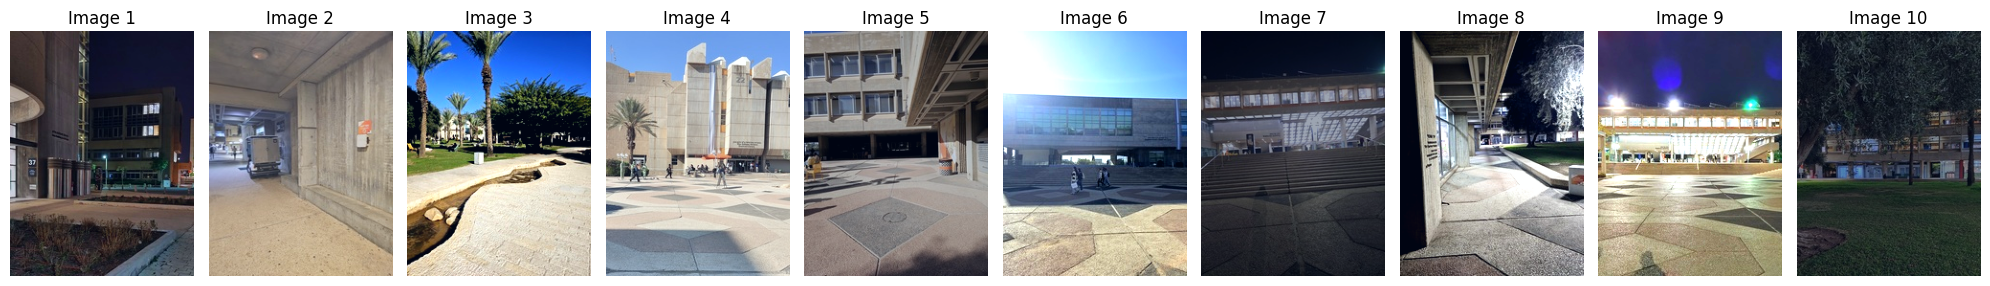

In [13]:
if __name__ == "__main__":

    # --- 4. DATASET INITIALIZATION ---
    print("Initializing Datasets...")
    train_dataset = GeolocalizationDataset(
        image_paths=train_df['path'].tolist(),
        coordinates=train_df[['lat', 'lon']].values,
        is_train=True
    )

    val_dataset = GeolocalizationDataset(
        image_paths=val_df['path'].tolist(),
        coordinates=val_df[['lat', 'lon']].values,
        is_train=False
    )

    # --- 5. THE DATALOADER ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0, #todo: tal try 4
        # persistent_workers=True,
        pin_memory=True)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0, #todo: tal try 4
        # persistent_workers=True,
        pin_memory=False)
    
    plot_images_from_dataloader(train_loader)

In [14]:
print(f"Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images.")

# --- 6. INITIALIZE MODEL ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_rtx = "RTX" in torch.cuda.get_device_name(0)

model = ConvNet2(use_dropout=True).to(device)

if is_rtx:
    model = model.to(memory_format=torch.channels_last) # Optimize for modern GPUs that prefer channels_last
else:
    print("RTX card not detected: Disabling AMP/Channels_Last optimizations")
    model = model.to(device)
    
print("Using device:", device)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


# --- 7. LOSS & OPTIMIZER ---
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


Training on 1183 images, Validating on 296 images.
RTX card not detected: Disabling AMP/Channels_Last optimizations
Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce GTX 1070


In [15]:
# --- 8. TRAINING & VALIDATION LOOP ---
train_losses = []
val_losses = []
val_dist_history = []
best_dist = float("inf")
patience_counter = 0
early_stopping_patience = 10
epochs = 100

print(f"Starting training on {device}...")

gradScaler = GradScaler('cuda') #scaler for mixed precision training, prevents gradient underflow

for epoch in tqdm(range(epochs) , desc="Epochs", unit="epoch"):
    # --- PHASE 1: TRAINING ---
    model.train()  # Dropout ON
    train_running_loss = 0.0

    for images, labels in train_loader:
        if is_rtx:
            images= images.to(device, memory_format=torch.channels_last) # Optimize for RTX GPUs that prefer channels_last
        else:
            images= images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        if is_rtx: # Use Mixed Precision Training only on RTX cards
            with autocast('cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            gradScaler.scale(loss).backward() 
            gradScaler.step(optimizer)        
            gradScaler.update()  

        else: # Standard training for non-RTX cards
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_running_loss += loss.item()

    # --- PHASE 2: VALIDATION ---
    model.eval()  # Set model to evaluation mode (disables Dropout)
    val_running_loss = 0.0
    total_distance = 0.0
    correct_50m = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # 1. Standard Prediction and MSE Loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # 2. Get Real-World Coordinates for Physical Metrics
            # Convert normalized predictions and labels back to GPS
            pred_normalized = outputs.cpu().numpy()
            true_normalized = labels.cpu().numpy()

            real_preds = scaler.inverse_transform(pred_normalized)  #
            real_trues = scaler.inverse_transform(true_normalized)  #

            # 3. Calculate Physical Distance Error
            distances = haversine_distance(real_preds, real_trues)

            # 4. Accumulate Statistics
            total_distance += np.sum(distances)
            correct_50m += np.sum(distances < 50)  # Count hits within 50m
            total_samples += len(labels)

    # --- PHASE 3: METRICS CALCULATION & PRINTING ---
    avg_train_loss = train_running_loss / len(train_loader)
    avg_val_loss = val_running_loss / len(val_loader)

    # Physical Metrics
    avg_dist_error = total_distance / total_samples  # Average error in meters
    accuracy_50m = (correct_50m / total_samples) * 100  # % Success rate

    # Keep history for plots
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_dist_history.append(avg_dist_error)

    # Log results
    print(f"Epoch [{epoch + 1}/{epochs}]")
    print(f"  -> Loss (MSE): Train {avg_train_loss:.6f} | Val {avg_val_loss:.6f}")
    print(
        f"  -> Reality: Avg Error {avg_dist_error:.1f}m | Accuracy@50m: {accuracy_50m:.1f}%"
    )
    print("-" * 30)

    # -- SCHEDULER --
    # 1. Step the scheduler based on physical error
    scheduler.step(avg_dist_error)

    # 2. Save the BEST version of YOUR model
    if avg_dist_error < best_dist:
        best_dist = avg_dist_error
        torch.save(model.state_dict(), "custom_geo_model_best.pth")
        patience_counter = 0
        print(f"  *** NEW BEST: {best_dist:.1f}m ***")
    else:
        patience_counter += 1
        print(
            f"  (No improvement for {patience_counter}/{early_stopping_patience} epochs)"
        )

    print("-" * 30)

    # 3. Early Stopping check
    if patience_counter >= early_stopping_patience:
        print("Model stopped improving. Ending training early.")
        break 

Starting training on cuda...


Epochs:   1%|          | 1/100 [00:10<18:00, 10.91s/epoch]

Epoch [1/100]
  -> Loss (MSE): Train 0.085195 | Val 0.075500
  -> Reality: Avg Error 87.7m | Accuracy@50m: 36.5%
------------------------------
  *** NEW BEST: 87.7m ***
------------------------------


Epochs:   2%|▏         | 2/100 [00:17<13:26,  8.23s/epoch]

Epoch [2/100]
  -> Loss (MSE): Train 0.064767 | Val 0.058447
  -> Reality: Avg Error 80.5m | Accuracy@50m: 30.4%
------------------------------
  *** NEW BEST: 80.5m ***
------------------------------


Epochs:   3%|▎         | 3/100 [00:24<12:24,  7.68s/epoch]

Epoch [3/100]
  -> Loss (MSE): Train 0.061682 | Val 0.057762
  -> Reality: Avg Error 78.3m | Accuracy@50m: 32.4%
------------------------------
  *** NEW BEST: 78.3m ***
------------------------------


Epochs:   4%|▍         | 4/100 [00:30<11:30,  7.19s/epoch]

Epoch [4/100]
  -> Loss (MSE): Train 0.056030 | Val 0.060387
  -> Reality: Avg Error 79.9m | Accuracy@50m: 34.8%
------------------------------
  (No improvement for 1/10 epochs)
------------------------------


Epochs:   5%|▌         | 5/100 [00:36<10:44,  6.78s/epoch]

Epoch [5/100]
  -> Loss (MSE): Train 0.057320 | Val 0.063241
  -> Reality: Avg Error 79.1m | Accuracy@50m: 38.2%
------------------------------
  (No improvement for 2/10 epochs)
------------------------------


Epochs:   6%|▌         | 6/100 [00:43<10:20,  6.60s/epoch]

Epoch [6/100]
  -> Loss (MSE): Train 0.058413 | Val 0.053707
  -> Reality: Avg Error 73.1m | Accuracy@50m: 39.5%
------------------------------
  *** NEW BEST: 73.1m ***
------------------------------


Epochs:   7%|▋         | 7/100 [00:49<10:06,  6.52s/epoch]

Epoch [7/100]
  -> Loss (MSE): Train 0.055603 | Val 0.052173
  -> Reality: Avg Error 72.8m | Accuracy@50m: 40.9%
------------------------------
  *** NEW BEST: 72.8m ***
------------------------------


Epochs:   8%|▊         | 8/100 [00:55<09:51,  6.43s/epoch]

Epoch [8/100]
  -> Loss (MSE): Train 0.055252 | Val 0.054410
  -> Reality: Avg Error 70.8m | Accuracy@50m: 44.3%
------------------------------
  *** NEW BEST: 70.8m ***
------------------------------


Epochs:   9%|▉         | 9/100 [01:03<10:13,  6.74s/epoch]

Epoch [9/100]
  -> Loss (MSE): Train 0.051617 | Val 0.049025
  -> Reality: Avg Error 68.8m | Accuracy@50m: 44.3%
------------------------------
  *** NEW BEST: 68.8m ***
------------------------------


Epochs:  10%|█         | 10/100 [01:10<10:12,  6.81s/epoch]

Epoch [10/100]
  -> Loss (MSE): Train 0.052021 | Val 0.061875
  -> Reality: Avg Error 75.8m | Accuracy@50m: 46.3%
------------------------------
  (No improvement for 1/10 epochs)
------------------------------


Epochs:  11%|█         | 11/100 [01:16<09:43,  6.56s/epoch]

Epoch [11/100]
  -> Loss (MSE): Train 0.053551 | Val 0.047149
  -> Reality: Avg Error 64.1m | Accuracy@50m: 49.3%
------------------------------
  *** NEW BEST: 64.1m ***
------------------------------


Epochs:  12%|█▏        | 12/100 [01:22<09:31,  6.49s/epoch]

Epoch [12/100]
  -> Loss (MSE): Train 0.051099 | Val 0.058370
  -> Reality: Avg Error 70.7m | Accuracy@50m: 48.6%
------------------------------
  (No improvement for 1/10 epochs)
------------------------------


Epochs:  13%|█▎        | 13/100 [01:28<09:26,  6.51s/epoch]

Epoch [13/100]
  -> Loss (MSE): Train 0.049843 | Val 0.067566
  -> Reality: Avg Error 79.4m | Accuracy@50m: 44.9%
------------------------------
  (No improvement for 2/10 epochs)
------------------------------


Epochs:  14%|█▍        | 14/100 [01:36<09:51,  6.88s/epoch]

Epoch [14/100]
  -> Loss (MSE): Train 0.051607 | Val 0.046853
  -> Reality: Avg Error 69.4m | Accuracy@50m: 41.6%
------------------------------
  (No improvement for 3/10 epochs)
------------------------------


Epochs:  15%|█▌        | 15/100 [01:45<10:23,  7.34s/epoch]

Epoch [15/100]
  -> Loss (MSE): Train 0.050135 | Val 0.047882
  -> Reality: Avg Error 68.1m | Accuracy@50m: 43.6%
------------------------------
  (No improvement for 4/10 epochs)
------------------------------


Epochs:  16%|█▌        | 16/100 [01:52<10:12,  7.29s/epoch]

Epoch [16/100]
  -> Loss (MSE): Train 0.046026 | Val 0.055931
  -> Reality: Avg Error 69.4m | Accuracy@50m: 45.3%
------------------------------
  (No improvement for 5/10 epochs)
------------------------------


Epochs:  17%|█▋        | 17/100 [01:58<09:45,  7.05s/epoch]

Epoch [17/100]
  -> Loss (MSE): Train 0.046162 | Val 0.046431
  -> Reality: Avg Error 63.3m | Accuracy@50m: 51.0%
------------------------------
  *** NEW BEST: 63.3m ***
------------------------------


Epochs:  17%|█▋        | 17/100 [02:04<10:06,  7.31s/epoch]


KeyboardInterrupt: 

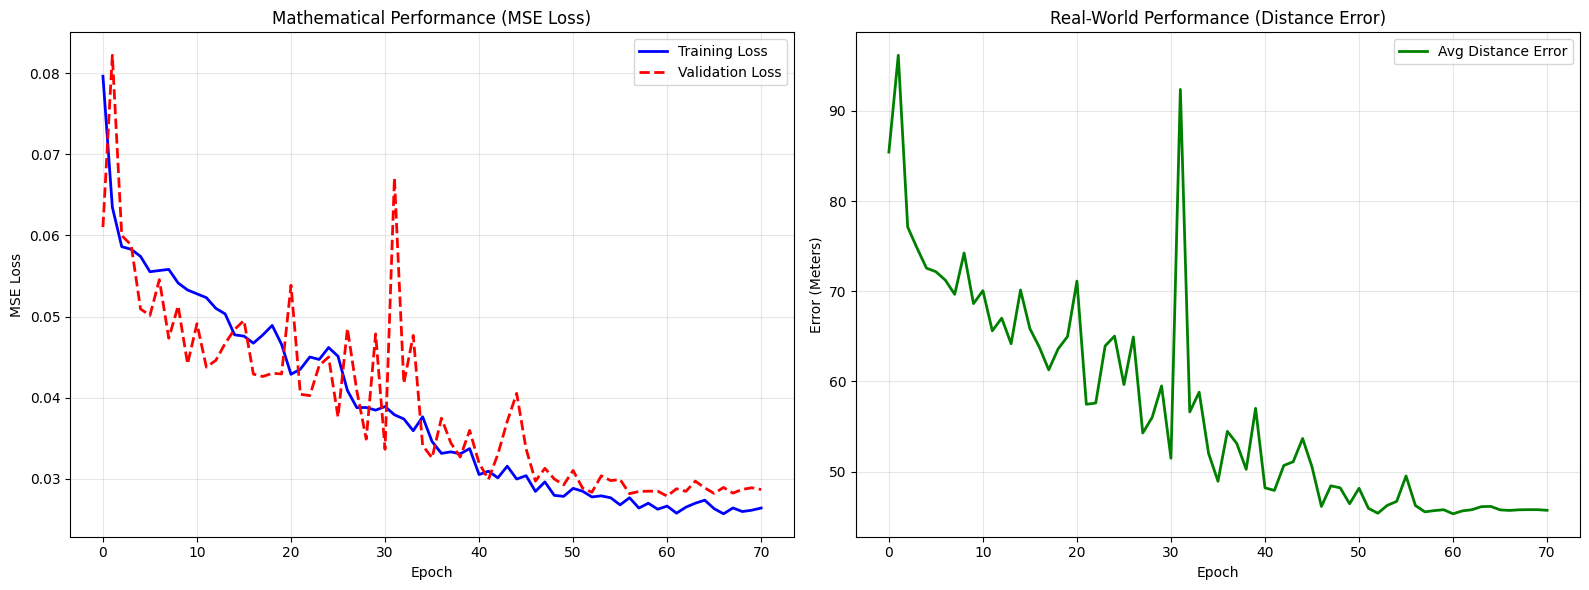


Training finished! Best Validation Error: 45.3 meters.
Model saved as 'geo_model.pth'


In [ ]:
# --- 9. SAVE THE MODEL & GENERATE PLOTS ---

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: MSE Loss (Training vs Validation)
ax1.plot(train_losses, label="Training Loss", color="blue", linewidth=2)
ax1.plot(val_losses, label="Validation Loss", color="red", linestyle="--", linewidth=2)
ax1.set_title("Mathematical Performance (MSE Loss)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right Plot: Physical Distance Error (Meters)
ax2.plot(val_dist_history, label="Avg Distance Error", color="green", linewidth=2)
ax2.set_title("Real-World Performance (Distance Error)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Error (Meters)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the model weights
torch.save(model.state_dict(), "geo_model.pth")
print(f"\nTraining finished! Best Validation Error: {best_dist:.1f} meters.")
print("Model saved as 'geo_model.pth'")

In [ ]:

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALER_PATH = 'coordinate_scaler.pkl'
MODEL_WEIGHTS_PATH = 'geo_model.pth'

# Loading Model and Scaler
# Initialize the model architecture and move to the device (GPU/CPU)
model = ConvNet().to(device)

# Load the trained weights from the .pth file
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

# Set the model to evaluation mode (disables Dropout and Batchnorm layers)
model.eval()

# Load the MinMaxScaler used during training to reverse the normalization
scaler = joblib.load(SCALER_PATH)

# Image Preprocessing Function
def predict_location(image_path):

    # Load the image and ensure it is in RGB format
    img = Image.open(image_path).convert('RGB')
    
    # Apply the same validation transforms (No augmentations here!)
    preprocess = T.Compose([
        T.Resize(256),
        T.CenterCrop(256),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Add a batch dimension (Batch size of 1) and move the tensor to device
    img_tensor = preprocess(img).unsqueeze(0).to(device) 
    
    # Perform inference without calculating gradients
    with torch.no_grad():
        output = model(img_tensor)
    
    # Convert the prediction back to a NumPy array on the CPU
    prediction_normalized = output.cpu().numpy()
    
    # Reverse the scaling to get real-world GPS coordinates
    real_coords = scaler.inverse_transform(prediction_normalized)
    
    # Return the first (and only) result in the batch [Latitude, Longitude]
    return real_coords[0]

# Run Inference on a New Image
# Provide the full path to your local image file
test_path = r"C:\path\to\your\new\image.jpg"
lat, lon = predict_location(test_path)

print(f"Predicted Location: Latitude {lat:.6f}, Longitude {lon:.6f}")
print(f"Google Maps Link: http://maps.google.com/maps?q={lat},{lon}")

RuntimeError: Error(s) in loading state_dict for ConvNet:
	Unexpected key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", "conv3.weight", "conv3.bias", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn3.num_batches_tracked", "conv4.weight", "conv4.bias", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var", "bn4.num_batches_tracked". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 3, 5, 5]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([256, 64]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([2, 512]) from checkpoint, the shape in current model is torch.Size([2, 256]).